In [1]:
import math

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from rl_helper.envs import create_vectorized_envs
from rl_helper.envs.pointmass.pointmass_env import PointMassParams
from torch.distributions import Normal

plt.rcParams["text.usetex"] = True
AXIS_FONT_SIZE = 20
POLICY_POINT_SIZE = 34
MIN_POLICY_WEIGHT = -2.0
MAX_POLICY_WEIGHT = 2.0
GRID_DENSITY = 51
NUM_POLICY_UPDATES = 100
POLICY_TRAJ_CMAP = "spring"
SAVE_KWARGS = {"bbox_inches": "tight", "pad_inches": 0.1}

use_params = PointMassParams(clip_actions=True, radius=1.0)

In [2]:
class Policy(nn.Module):
    def __init__(self, weight_scale=0.1):
        super().__init__()
        self.weight = nn.Parameter(weight_scale * torch.randn(2))
        self.logstd = nn.Parameter(torch.zeros(1, 1))

    def forward(self, state):
        mean = state * self.weight
        logstd = self.logstd.expand_as(mean)
        return Normal(mean, logstd.exp())

In [3]:
def evaluate(num_eval_episodes, policy, envs):
    obs = envs.reset()
    total_rewards = []
    while len(total_rewards) < num_eval_episodes:
        action_distrib = policy(obs)
        use_action = action_distrib.mean
        obs, _, done, info = envs.step(use_action)
        for done_i in torch.nonzero(done):
            # dists_to_goal.append(info[done_i]["dist_to_goal"])
            total_rewards.append(info[done_i]["episode"]["r"])
    return sum(total_rewards) / len(total_rewards)

In [4]:
def plot_true_performance(envs):
    policy_values = torch.zeros(GRID_DENSITY, GRID_DENSITY)
    weight_X = torch.linspace(MIN_POLICY_WEIGHT, MAX_POLICY_WEIGHT, GRID_DENSITY)
    weight_Y = torch.linspace(MIN_POLICY_WEIGHT, MAX_POLICY_WEIGHT, GRID_DENSITY)
    policy = Policy()
    # Grid over [-2,0]^2
    max_val = -10000
    max_weight = None

    for i, weight_x in enumerate(weight_X):
        for j, weight_y in enumerate(weight_Y):
            policy.weight.data.copy_(torch.tensor([weight_x, weight_y]))
            policy_values[i, j] = evaluate(1, policy, envs)
            if policy_values[i, j] > max_val:
                max_val = policy_values[i, j]
                max_weight = [weight_x, weight_y]

    fig = plt.imshow(
        policy_values,
        extent=[
            MIN_POLICY_WEIGHT,
            MAX_POLICY_WEIGHT,
            MIN_POLICY_WEIGHT,
            MAX_POLICY_WEIGHT,
        ],
        origin="lower",
    )
    plt.xlabel("$\\theta_1$", fontsize=AXIS_FONT_SIZE)
    plt.ylabel("$\\theta_2$", fontsize=AXIS_FONT_SIZE)
    print(f"Best parameters {max_weight} with value {max_val}")


# envs = create_vectorized_envs(
#     "PointMass-v0",
#     32,
#     params=use_params,
# )
# plot_true_performance(envs)
# plt.colorbar()
# plt.savefig("data/perf_gt.png", **SAVE_KWARGS)
# plt.show(block=False)
# plt.clf()

In [4]:
def compute_returns(rewards, masks, gamma):
    returns = torch.zeros(rewards.shape[0] + 1, *rewards.shape[1:])
    for step in reversed(range(rewards.size(0))):
        returns[step] = returns[step + 1] * gamma * masks[step + 1] + rewards[step]
    return returns


def rollout_policy(policy, envs, num_steps):
    all_obs = torch.zeros(num_steps + 1, envs.num_envs, envs.observation_space.shape[0])
    all_rewards = torch.zeros(num_steps, envs.num_envs, 1)
    all_actions = torch.zeros(num_steps, envs.num_envs, envs.action_space.shape[0])
    all_masks = torch.zeros(num_steps + 1, envs.num_envs, 1)

    obs = envs.reset()
    all_obs[0].copy_(obs)

    for step_idx in range(num_steps):
        with torch.no_grad():
            action_distrib = policy(obs)
            take_action = action_distrib.sample()

        obs, reward, done, info = envs.step(take_action)
        all_obs[step_idx + 1].copy_(obs)
        all_rewards[step_idx].copy_(reward)
        all_actions[step_idx].copy_(take_action)
        all_masks[step_idx].copy_((~done).float().view(-1, 1))
    return all_obs, all_rewards, all_actions, all_masks

Update #0: Reward -0.4728
Maximum possible reward is  tensor(-0.1698)


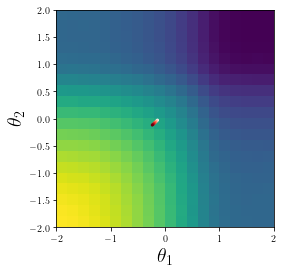

In [17]:


def train_policy(envs, num_steps, num_updates, gamma=0.99, lr=1e-2, policy=None):
    if policy is None:
        policy = Policy()
    opt = torch.optim.Adam(lr=lr, params=policy.parameters())
    log_interval = 20

    weight_seq = [policy.weight.data.detach().clone()]
    for update_i in range(num_updates):
        obs, rewards, actions, masks = rollout_policy(policy, envs, num_steps)
        returns = compute_returns(rewards, masks, gamma)
        log_probs = policy(obs[:-1]).log_prob(actions).sum(-1, keepdim=True)
        loss = (-returns[:-1] * log_probs).mean()
        opt.zero_grad()
        loss.backward()
        opt.step()
        if policy.weight[0] < MIN_POLICY_WEIGHT or policy.weight[1] < MIN_POLICY_WEIGHT:
            break
        weight_seq.append(policy.weight.detach().clone())

    weight_seq = torch.stack(weight_seq, dim=0)
    return weight_seq


envs = create_vectorized_envs(
    "PointMass-v0",
    256,
    params=use_params,
)

weight_seq = train_policy(envs, num_steps=5, num_updates=NUM_POLICY_UPDATES)
plot_true_performance(envs)
fig = plt.scatter(
    weight_seq[:, 0],
    weight_seq[:, 1],
    c=torch.arange(weight_seq.size(0)),
    s=POLICY_POINT_SIZE,
    cmap=plt.get_cmap(POLICY_TRAJ_CMAP),
)
plt.savefig("data/perf_reinforce_opt.png", **SAVE_KWARGS)
plt.show(block=False)
plt.clf()

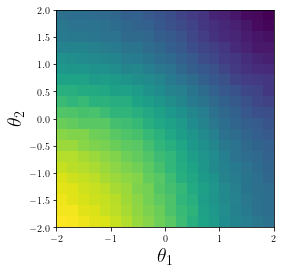

In [19]:
# Compute the loss function estimate as a function of the batch size.
weight_X = torch.linspace(MIN_POLICY_WEIGHT, MAX_POLICY_WEIGHT, GRID_DENSITY)
weight_Y = torch.linspace(MIN_POLICY_WEIGHT, MAX_POLICY_WEIGHT, GRID_DENSITY)

for num_envs in [1, 2, 4, 16, 32, 64, 128, 1024]:
    envs = create_vectorized_envs(
        "PointMass-v0",
        num_envs,
        params=use_params,
    )
    policy_values = torch.zeros(GRID_DENSITY, GRID_DENSITY)
    policy = Policy()
    for i, weight_x in enumerate(weight_X):
        for j, weight_y in enumerate(weight_Y):
            policy.weight.data.copy_(torch.tensor([weight_x, weight_y]))
            obs, rewards, actions, masks = rollout_policy(policy, envs, num_steps=5)
            returns = compute_returns(rewards, masks, gamma=0.99)

            log_probs = policy(obs[:-1]).log_prob(actions).sum(-1, keepdim=True)
            loss = (-returns[:-1] * log_probs).mean()
            policy_values[i, j] = loss.item()

    plt.clf()
    fig = plt.imshow(
        policy_values,
        extent=[
            MIN_POLICY_WEIGHT,
            MAX_POLICY_WEIGHT,
            MIN_POLICY_WEIGHT,
            MAX_POLICY_WEIGHT,
        ],
        origin="lower",
    )
    plt.xlabel("$\\theta_1$", fontsize=AXIS_FONT_SIZE)
    plt.ylabel("$\\theta_2$", fontsize=AXIS_FONT_SIZE)
    plt.savefig(f"data/perf_est_{num_envs}.png", **SAVE_KWARGS)

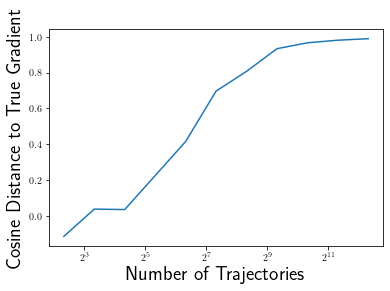

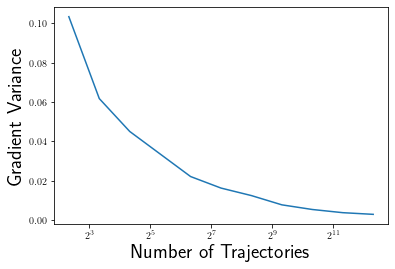

<Figure size 432x288 with 0 Axes>

In [6]:
# Compute the gradient accuracy/variance
def get_loss(policy, envs):
    obs, rewards, actions, masks = rollout_policy(policy, envs, num_steps=5)
    returns = compute_returns(rewards, masks, gamma=0.99)
    log_probs = policy(obs[:-1]).log_prob(actions).sum(-1, keepdim=True)
    return (-returns[:-1] * log_probs).mean()


def compute_grad_mean_vars(env_params, env_sizes):
    policy = Policy()
    envs = create_vectorized_envs(
        "PointMass-v0",
        10000,
        params=env_params,
    )
    true_loss = get_loss(policy, envs)
    policy.zero_grad()
    true_loss.backward()
    true_grad = policy.weight.grad.detach().clone()

    cosine_dist = nn.CosineSimilarity(dim=-1)
    dists = []
    all_pairwise_dists = []
    n_samples = 100

    for num_envs in env_sizes:
        envs = create_vectorized_envs(
            "PointMass-v0",
            num_envs,
            params=use_params,
        )

        all_grads = []
        for _ in range(n_samples):
            policy.zero_grad()
            loss = get_loss(policy, envs)
            loss.backward()
            all_grads.append(policy.weight.grad.detach().clone())
        all_grads = torch.stack(all_grads, 0)

        dists.append(cosine_dist(all_grads, true_grad).mean())
        all_pairwise_dists.append(all_grads.std(0).mean())

    return dists, all_pairwise_dists


env_sizes = torch.tensor([1, 2, 4, 16, 32, 64, 128, 256, 512, 1024])
grad_acc, grad_var = compute_grad_mean_vars(use_params, env_sizes)

plt.plot(env_sizes * 5, grad_acc)
plt.xscale("log", base=2)
plt.xlabel("Number of Trajectories", fontsize=AXIS_FONT_SIZE)
plt.ylabel("Cosine Distance to True Gradient", fontsize=AXIS_FONT_SIZE)
plt.savefig(f"data/grad_accuracy.png")
plt.show(block=False)
plt.clf()

plt.plot(env_sizes * 5, grad_var)
plt.xscale("log", base=2)
plt.xlabel("Number of Trajectories", fontsize=AXIS_FONT_SIZE)
plt.ylabel("Gradient Variance", fontsize=AXIS_FONT_SIZE)
plt.savefig(f"data/grad_var.png")
plt.show(block=False)
plt.clf()

Best parameters [tensor(-2.), tensor(-2.)] with value 2.0


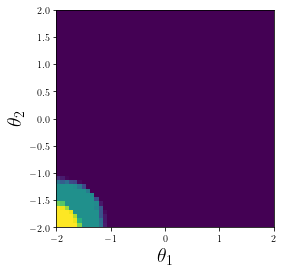

<Figure size 432x288 with 0 Axes>

In [5]:
def sparse_reward(cur_dist, prev_dist):
    reward = torch.zeros(cur_dist.shape)
    reward[cur_dist < 0.2] = 1.0
    return reward


sparse_reward_params = PointMassParams(
    clip_actions=True, radius=1.0, custom_reward=sparse_reward
)

envs = create_vectorized_envs(
    "PointMass-v0",
    32,
    params=sparse_reward_params,
)
plot_true_performance(envs)
plt.savefig("data/sparse_reward_perf.png", **SAVE_KWARGS)
plt.show(block=False)
plt.clf()

In [ ]:
all_eval_results = []
for seed_i in range(100):
    weight_seq = train_policy(
        envs,
        num_steps=5,
        num_updates=50,
        lr=1e-1,
        policy=Policy(),
    )
    eval_policy = Policy()
    eval_policy.weight.data.copy_(weight_seq[-1])
    all_eval_results.append(evaluate(5, eval_policy, envs))
    if seed_i > 10:
        continue
    fig = plt.scatter(
        weight_seq[:, 0],
        weight_seq[:, 1],
        c=torch.arange(weight_seq.size(0)),
        s=POLICY_POINT_SIZE,
        cmap=plt.get_cmap(POLICY_TRAJ_CMAP),
    )
print(
    "% that achieved goal",
    sum(1 for v in all_eval_results if v > 0) / len(all_eval_results),
)
plt.savefig("data/sparse_reward_opt.png", **SAVE_KWARGS)
plt.show(block=False)
plt.clf()